In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('Data/monthly_champagne_sales.csv', index_col=0, parse_dates=True)
df

,Sales
Month,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946
...,...
1972-05-01,4618
1972-06-01,5312
1972-07-01,4298


In [3]:
df.describe()

,Sales
count,105.000000
mean,4761.152381
std,2553.502601
min,1413.000000
25%,3113.000000
50%,4217.000000
75%,5221.000000
max,13916.000000


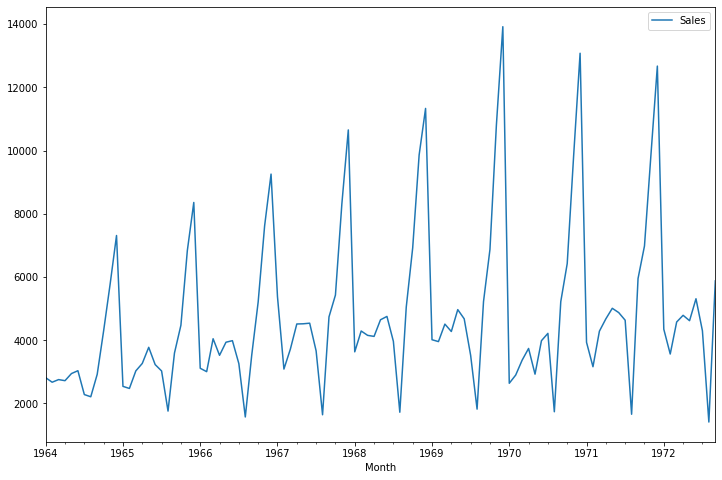

In [4]:
df.plot(figsize=(12,8));

* we will pretend that it is September 1971 and withhold the last one year
of data from analysis and model selection. This nal year of data will be used to validate the final model.

    * Observations from January 1964 to September 1971 (93 observations).
    * validation.csv: Observations from October 1971 to September 1972 (12 observations).
   
The validation dataset is 11% of the original dataset.

In [5]:
data = df[:-12]
data

,Sales
Month,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946
...,...
1971-05-01,5010
1971-06-01,4874
1971-07-01,4633


In [6]:
validation = df[-12:]
print(validation.info())
validation

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12 entries, 1971-10-01 to 1972-09-01
Data columns (total 1 columns):
Sales    12 non-null int64
dtypes: int64(1)
memory usage: 192.0 bytes
None


,Sales
Month,
1971-10-01,6981
1971-11-01,9851
1971-12-01,12670
1972-01-01,4348
1972-02-01,3564
1972-03-01,4577
1972-04-01,4788
1972-05-01,4618
1972-06-01,5312


### Test Strategy

Candidate models will be evaluated using walk-forward validation. The walk-forward validation will work as follows:

1. The first 50% of the dataset will be held back to train the model.
2. The remaining 50% of the dataset will be iterated and test the model.
3. A one-step prediction made.

In [7]:
X =data

train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]

### Persistence

* The baseline prediction for time series forecasting is called the naive forecast, or persistence. This is where the observation from the previous time step is used as the prediction
for the observation at the next time step. 

In [8]:
from sklearn.metrics import mean_squared_error
from math import sqrt

test['pred'] = test['Sales'].shift()

C:\Anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [9]:
#get first prediction from the last observation of train dataset

test.loc['1967-11-01','pred']=train['Sales'][-1]

C:\Anaconda3\envs\myenv\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [10]:
test.head()

,Sales,pred
Month,,
1967-11-01,8314,5428.0
1967-12-01,10651,8314.0
1968-01-01,3633,10651.0
1968-02-01,4292,3633.0
1968-03-01,4154,4292.0


In [11]:
test['error'] = test['Sales'] - test['pred']


# report performance
rmse = sqrt(mean_squared_error(test['Sales'], test['pred']))
print('RMSE: %.3f' % rmse)

RMSE: 3186.501


C:\Anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


* We now have a baseline prediction method and performance; now we can start digging into
our data.

In [12]:
from statsmodels.tsa.stattools import adfuller

def dickey_fuller_test(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [13]:
dickey_fuller_test(data)

Results of Dickey-Fuller Test:
Test Statistic                 -1.445970
p-value                         0.560050
#Lags Used                     11.000000
Number of Observations Used    81.000000
Critical Value (1%)            -3.513790
Critical Value (5%)            -2.897943
Critical Value (10%)           -2.586191
dtype: float64


* We can't reject the null hypothesis. It means that the process has  unit root and time series isn't stationary. Let's take a difference and test it again.

In [14]:
data_diff = data.diff(12).dropna()

dickey_fuller_test(data_diff)

Results of Dickey-Fuller Test:
Test Statistic                -7.134898e+00
p-value                        3.441294e-10
#Lags Used                     0.000000e+00
Number of Observations Used    8.000000e+01
Critical Value (1%)           -3.514869e+00
Critical Value (5%)           -2.898409e+00
Critical Value (10%)          -2.586439e+00
dtype: float64


* We can reject the null hypothesis. It means that the process has no unit root, and in turn that the 12-lag differenced time series is stationary or does not have time-dependent structure.

* This suggests that at least one level of differencing is required. The d parameter in our ARIMA model should at least be a value of 1. The next step is to select the lag values for the Autoregression (AR) and Moving Average (MA) parameters, p and q respectively. We can do this by reviewing Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots. The example below creates ACF and PACF plots for the series.

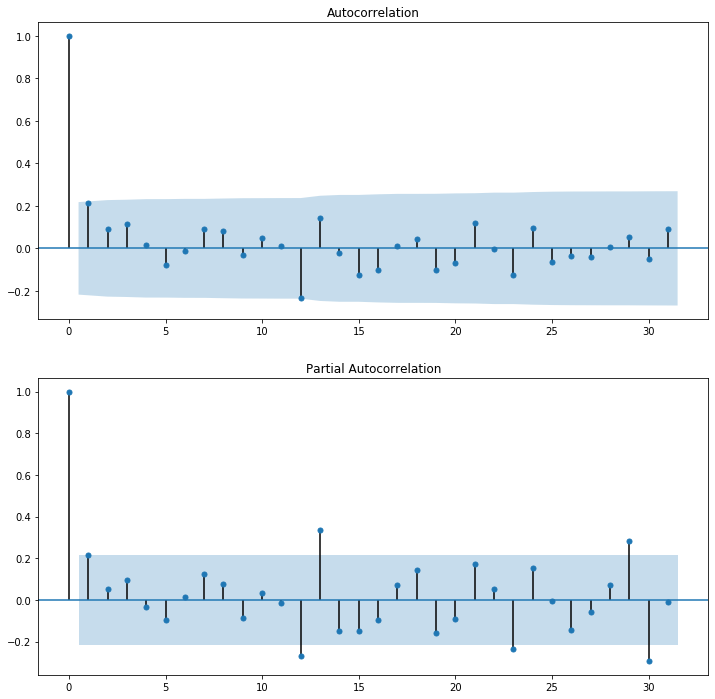

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2,1,figsize=(12, 12))

plot_acf(data_diff, lags=31, ax=ax[0])
plot_pacf(data_diff, lags=31, ax=ax[1])

plt.show()

* Let's try ARIMA (1,1,1) on data_diff from book

In [136]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(data_diff, order=(1,1,1))

# Make predictions for last 53 values
results = model.fit()

# Make in-sample prediction
forecast = results.get_prediction(start=-47)

In [137]:
forecast.predicted_mean

1967-11-01    411.935039
1967-12-01    528.282641
1968-01-01    708.127066
1968-02-01    -60.499742
1968-03-01    632.741359
1968-04-01    455.557196
1968-05-01    248.893110
1968-06-01    362.621187
1968-07-01    378.674345
1968-08-01    396.667651
1968-09-01    339.828274
1968-10-01    390.521067
1968-11-01    679.818506
1968-12-01    709.058764
1969-01-01    514.673259
1969-02-01    445.420725
1969-03-01    269.055533
1969-04-01    425.718084
1969-05-01    375.520600
1969-06-01    411.742891
1969-07-01    313.818716
1969-08-01    218.213439
1969-09-01    337.221746
1969-10-01    351.450684
1969-11-01    294.395897
1969-12-01    528.427008
1970-01-01    930.027943
1970-02-01      4.111330
1970-03-01     58.782035
1970-04-01     21.635519
1970-05-01    148.520571
1970-06-01   -222.261288
1970-07-01     73.533349
1970-08-01    393.319519
1970-09-01    212.129423
1970-10-01    227.473026
1970-11-01    117.686501
1970-12-01    -12.378984
1971-01-01      3.408374
1971-02-01    499.757920


In [138]:
forecast.predicted_mean.values

array([ 411.93503882,  528.28264058,  708.12706555,  -60.49974197,
        632.74135927,  455.55719619,  248.89310983,  362.62118726,
        378.67434522,  396.66765064,  339.82827369,  390.52106692,
        679.81850583,  709.05876384,  514.67325909,  445.42072511,
        269.05553273,  425.71808446,  375.52059959,  411.74289146,
        313.81871558,  218.21343948,  337.22174649,  351.45068429,
        294.39589737,  528.4270076 ,  930.02794256,    4.11133049,
         58.7820346 ,   21.6355186 ,  148.52057149, -222.26128807,
         73.53334897,  393.31951887,  212.12942306,  227.47302562,
        117.68650093,  -12.37898436,    3.40837432,  499.75791982,
        265.12334529,  420.16463861,  431.35907234,  709.83137431,
        444.05615441,  337.837227  ,  221.6570449 ])

In [139]:
data.Sales[-59:-12]

Month
1966-11-01     7614
1966-12-01     9254
1967-01-01     5375
1967-02-01     3088
1967-03-01     3718
1967-04-01     4514
1967-05-01     4520
1967-06-01     4539
1967-07-01     3663
1967-08-01     1643
1967-09-01     4739
1967-10-01     5428
1967-11-01     8314
1967-12-01    10651
1968-01-01     3633
1968-02-01     4292
1968-03-01     4154
1968-04-01     4121
1968-05-01     4647
1968-06-01     4753
1968-07-01     3965
1968-08-01     1723
1968-09-01     5048
1968-10-01     6922
1968-11-01     9858
1968-12-01    11331
1969-01-01     4016
1969-02-01     3957
1969-03-01     4510
1969-04-01     4276
1969-05-01     4968
1969-06-01     4677
1969-07-01     3523
1969-08-01     1821
1969-09-01     5222
1969-10-01     6872
1969-11-01    10803
1969-12-01    13916
1970-01-01     2639
1970-02-01     2899
1970-03-01     3370
1970-04-01     3740
1970-05-01     2927
1970-06-01     3986
1970-07-01     4217
1970-08-01     1738
1970-09-01     5221
Name: Sales, dtype: int64

In [140]:
data.Sales[-59:-12].values

array([ 7614,  9254,  5375,  3088,  3718,  4514,  4520,  4539,  3663,
        1643,  4739,  5428,  8314, 10651,  3633,  4292,  4154,  4121,
        4647,  4753,  3965,  1723,  5048,  6922,  9858, 11331,  4016,
        3957,  4510,  4276,  4968,  4677,  3523,  1821,  5222,  6872,
       10803, 13916,  2639,  2899,  3370,  3740,  2927,  3986,  4217,
        1738,  5221], dtype=int64)

In [141]:
prediction_undifferenced = forecast.predicted_mean.values + data.Sales[-59:-12].values
prediction_undifferenced

array([ 8025.93503882,  9782.28264058,  6083.12706555,  3027.50025803,
        4350.74135927,  4969.55719619,  4768.89310983,  4901.62118726,
        4041.67434522,  2039.66765064,  5078.82827369,  5818.52106692,
        8993.81850583, 11360.05876384,  4147.67325909,  4737.42072511,
        4423.05553273,  4546.71808446,  5022.52059959,  5164.74289146,
        4278.81871558,  1941.21343948,  5385.22174649,  7273.45068429,
       10152.39589737, 11859.4270076 ,  4946.02794256,  3961.11133049,
        4568.7820346 ,  4297.6355186 ,  5116.52057149,  4454.73871193,
        3596.53334897,  2214.31951887,  5434.12942306,  7099.47302562,
       10920.68650093, 13903.62101564,  2642.40837432,  3398.75791982,
        3635.12334529,  4160.16463861,  3358.35907234,  4695.83137431,
        4661.05615441,  2075.837227  ,  5442.6570449 ])

In [142]:
pred = pd.Series(prediction_undifferenced, index= pd.date_range(start='1967-11-01', end='1971-09-01', freq='MS'))
pred

1967-11-01     8025.935039
1967-12-01     9782.282641
1968-01-01     6083.127066
1968-02-01     3027.500258
1968-03-01     4350.741359
1968-04-01     4969.557196
1968-05-01     4768.893110
1968-06-01     4901.621187
1968-07-01     4041.674345
1968-08-01     2039.667651
1968-09-01     5078.828274
1968-10-01     5818.521067
1968-11-01     8993.818506
1968-12-01    11360.058764
1969-01-01     4147.673259
1969-02-01     4737.420725
1969-03-01     4423.055533
1969-04-01     4546.718084
1969-05-01     5022.520600
1969-06-01     5164.742891
1969-07-01     4278.818716
1969-08-01     1941.213439
1969-09-01     5385.221746
1969-10-01     7273.450684
1969-11-01    10152.395897
1969-12-01    11859.427008
1970-01-01     4946.027943
1970-02-01     3961.111330
1970-03-01     4568.782035
1970-04-01     4297.635519
1970-05-01     5116.520571
1970-06-01     4454.738712
1970-07-01     3596.533349
1970-08-01     2214.319519
1970-09-01     5434.129423
1970-10-01     7099.473026
1970-11-01    10920.686501
1

In [143]:
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy as np

rmse = sqrt(mean_squared_error(test.Sales, pred))
print('RMSE: %.3f' % rmse)

RMSE: 916.320


* Running this example results in an RMSE of 916.320, which is dramatically better than the persistence RMSE of 3186.501

In [145]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                   81
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -648.288
Date:                Tue, 28 Apr 2020   AIC                           1302.577
Time:                        11:36:32   BIC                           1309.723
Sample:                    01-01-1965   HQIC                          1305.442
                         - 09-01-1971                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2243      0.087      2.587      0.010       0.054       0.394
ma.L1         -0.9993      1.014     -0.985      0.324      -2.987       0.989
sigma2      6.122e+05   6.11e+05      1.001      0.317   -5.86e+05    1.81e+06
===================================================================================
Ljung-Box (Q):                       49.55   Jarque-Bera (JB):                 8.84
Prob(Q):                              0.14   Prob(JB):                         0.01
Heteroskedasticity (H):               2.95   Skew:                            -0.35
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

* Prob(Q) - p-value for null hypothesis that residuals are uncorrelated
* Prob(JB) - p-value for null hypothesis that residuals are normal

residuals are uncorrelated but not normally distributed!!!

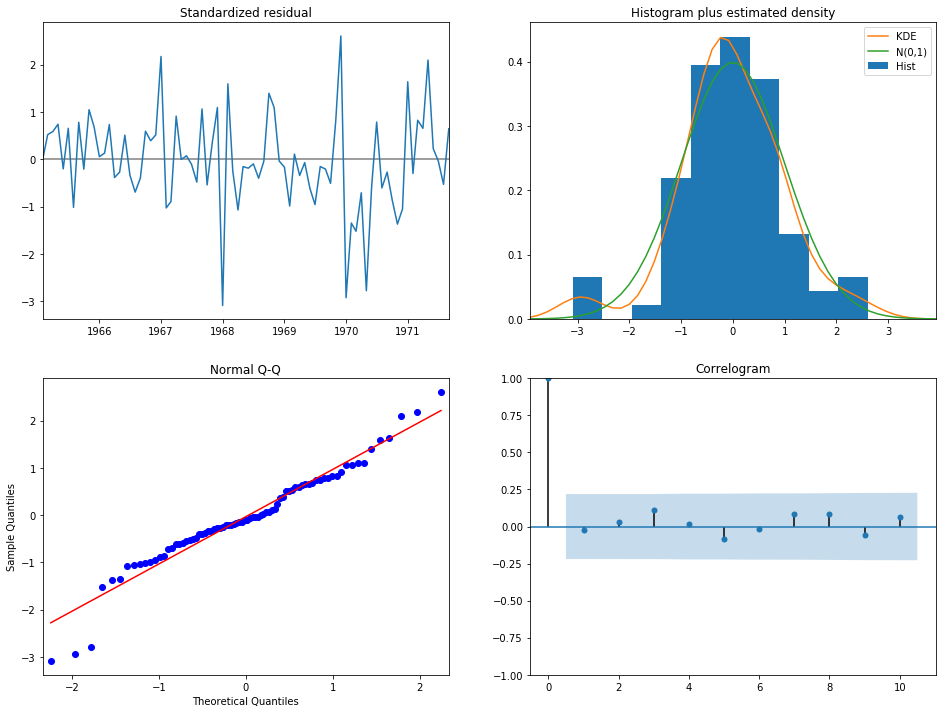

In [146]:
# Create the 4 diagostics plots
results.plot_diagnostics(figsize=(16,12))
plt.show()

In [147]:
results.resid.describe()

count      81.000000
mean      -26.031634
std       793.148811
min     -2450.127066
25%      -416.837227
50%       -86.036639
75%       515.304583
max      2056.572992
dtype: float64

In [148]:
bias = results.resid.describe().loc['mean']
bias

-26.031633978840034

### Searching over AIC and BIC

In [103]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

In [104]:
import itertools

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

In [105]:
# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


We can now use the triplets of parameters defined above to automate the process of training and evaluating ARIMA models on different combinations. In Statistics and Machine Learning, this process is known as grid search (or hyperparameter optimization) for model selection.

When evaluating and comparing statistical models fitted with different parameters, each can be ranked against one another based on how well it fits the data or its ability to accurately predict future data points. We will use the AIC (Akaike Information Criterion) value, which is conveniently returned with ARIMA models fitted using statsmodels. The AIC measures how well a model fits the data while taking into account the overall complexity of the model. A model that fits the data very well while using lots of features will be assigned a larger AIC score than a model that uses fewer features to achieve the same goodness-of-fit. Therefore, we are interested in finding the model that yields the lowest AIC value.

The code chunk below iterates through combinations of parameters and uses the SARIMAX function from statsmodels to fit the corresponding Seasonal ARIMA model. Here, the order argument specifies the (p, d, q) parameters, while the seasonal_order argument specifies the (P, D, Q, S) seasonal component of the Seasonal ARIMA model. After fitting each SARIMAX()model, the code prints out its respective AIC score.

In [108]:
import warnings

warnings.filterwarnings("ignore") # specify to ignore warning messages

aicVal=[]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(data,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            aicVal.append((param, param_seasonal, results.aic, results.bic))
        except:
            continue

In [109]:
val = pd.DataFrame(aicVal, columns=['pdq', 'PDQ X S', 'AIC', 'BIC'])
val.sort_values('AIC').head(20)

,pdq,PDQ X S,AIC,BIC
63,"(1, 1, 1)","(1, 1, 1, 12)",1079.089703,1090.037977
59,"(1, 1, 1)","(0, 1, 1, 12)",1079.290691,1088.049310
27,"(0, 1, 1)","(0, 1, 1, 12)",1080.296559,1086.865523
31,"(0, 1, 1)","(1, 1, 1, 12)",1081.670366,1090.428985
62,"(1, 1, 1)","(1, 1, 0, 12)",1093.960239,1102.779010
47,"(1, 0, 1)","(1, 1, 1, 12)",1095.085862,1106.109325
43,"(1, 0, 1)","(0, 1, 1, 12)",1095.581177,1104.399947
15,"(0, 0, 1)","(1, 1, 1, 12)",1096.563131,1105.381902
11,"(0, 0, 1)","(0, 1, 1, 12)",1099.674429,1106.288507
54,"(1, 1, 0)","(1, 1, 0, 12)",1106.926859,1113.540937


#### SARIMA (1,1,1) (1,1,1,12)

In [130]:
model = SARIMAX(data, order=(1,1,1), seasonal_order=(1,1,1,12), trend='c')

# Make predictions for last 53 values
results = model.fit()

# Make in-sample prediction
forecast = results.get_prediction(start=-47)

In [131]:
rmse = sqrt(mean_squared_error(test.Sales, forecast.predicted_mean))
print('RMSE: %.3f' % rmse)

RMSE: 829.895


In [132]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Sales   No. Observations:                   93
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -644.473
Date:                            Tue, 28 Apr 2020   AIC                           1300.945
Time:                                    11:34:24   BIC                           1315.237
Sample:                                01-01-1964   HQIC                          1306.675
                                     - 09-01-1971                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -9.2057      4.610     -1.997      0.046     -18.241      -0.171
ar.L1          0.2979      0.087      3.434      0.001       0.128       0.468
ma.L1         -1.0000      0.134     -7.468      0.000      -1.262      -0.738
ar.S.L12      -0.6050      0.268     -2.255      0.024      -1.131      -0.079
ma.S.L12       0.3508      0.279      1.257      0.209      -0.196       0.898
sigma2      5.133e+05   2.75e-07   1.87e+12      0.000    5.13e+05    5.13e+05
===================================================================================
Ljung-Box (Q):                       38.17   Jarque-Bera (JB):                 3.71
Prob(Q):                              0.55   Prob(JB):                         0.16
Heteroskedasticity (H):               1.90   Skew:                            -0.11
Prob(H) (two-sided):                  0.10   Kurtosis:                         4.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.94e+29. Standard errors may be unstable.
"""

##### The residuals are not correlated and are normally distributed !!!

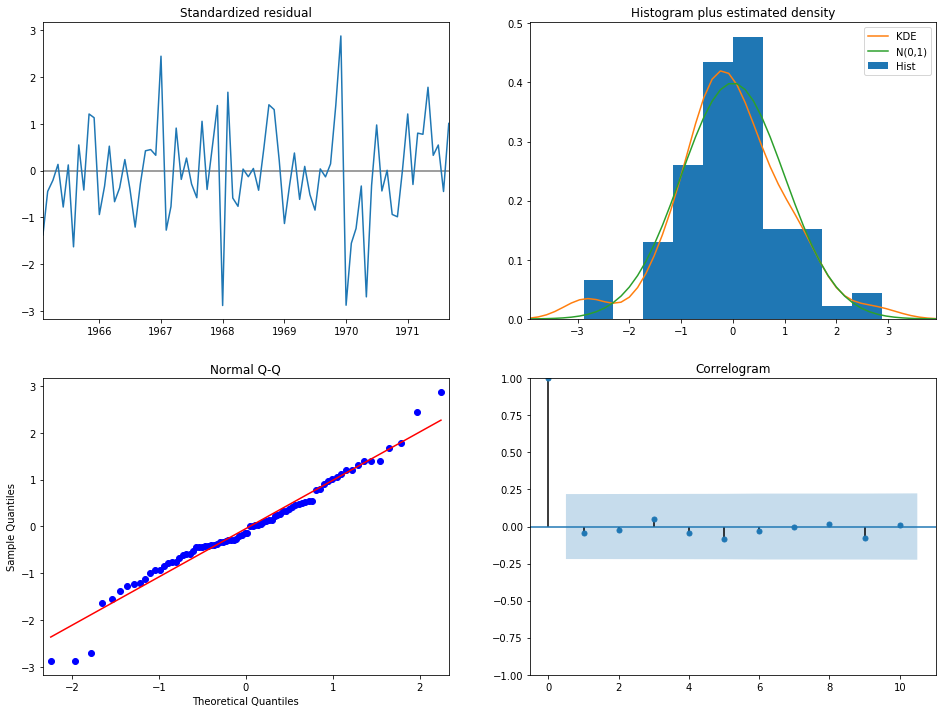

In [133]:
# Create the 4 diagostics plots
results.plot_diagnostics(figsize=(16,12))
plt.show()

In [134]:
results.resid.describe()

count      93.000000
mean       -4.861700
std      1037.858519
min     -5944.306243
25%      -372.316155
50%        24.427759
75%       395.058382
max      2823.169245
dtype: float64

In [135]:
bias = results.resid.describe().loc['mean']
bias

-4.8616998907632825

In [119]:
import pmdarima as pm


results = pm.auto_arima(data, # data
                        
                        start_p=0, # initial guess for p
                        start_q=0, # initial guess for q
                        
                        seasonal=True, # is the time series seasonal
                        m=12, # the seasonal period
                        D=1, # seasonal difference order
                        start_P=0, # initial guess for P
                        start_Q=0, # initial guess for Q
                        max_P=2, # max value of P to test
                        max_Q=2, # max value of Q to test
                       )

In [120]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   93
Model:             SARIMAX(1, 0, 0)x(1, 1, 0, 12)   Log Likelihood                -652.866
Date:                            Tue, 28 Apr 2020   AIC                           1313.732
Time:                                    11:01:49   BIC                           1323.309
Sample:                                         0   HQIC                          1317.574
                                             - 93                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    293.8148     97.680      3.008      0.003     102.366     485.263
ar.L1          0.2224      0.069      3.211      0.001       0.087       0.358
ar.S.L12      -0.1949      0.088     -2.204      0.028      -0.368      -0.022
sigma2      5.462e+05   6.64e+04      8.231      0.000    4.16e+05    6.76e+05
===================================================================================
Ljung-Box (Q):                       31.24   Jarque-Bera (JB):                 5.35
Prob(Q):                              0.84   Prob(JB):                         0.07
Heteroskedasticity (H):               2.10   Skew:                            -0.24
Prob(H) (two-sided):                  0.06   Kurtosis:                         4.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

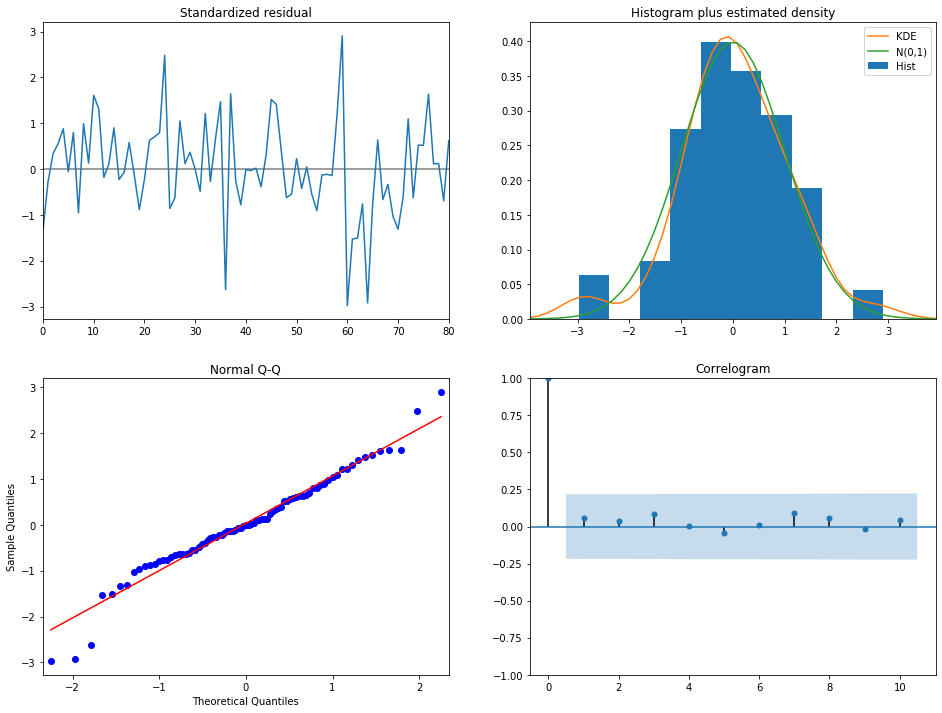

In [121]:
results.plot_diagnostics(figsize=(16,12));

In [122]:
# Instantiate model
model = SARIMAX(data, order=(1,0,0), seasonal_order=(1,1,0,12))

# Fit model
results = model.fit()

In [124]:
# Make in-sample prediction
forecast = results.get_prediction(start=-47)

In [126]:
rmse = sqrt(mean_squared_error(test.Sales, forecast.predicted_mean))
print('RMSE: %.3f' % rmse)

RMSE: 881.104


### Forecasting out of sample

#### SARIMA (1,1,1) (1,1,1,12)

In [159]:
model = SARIMAX(data, order=(1,1,1), seasonal_order=(1,1,1,12), trend='n')

results = model.fit()

# Make out-of-sample prediction
forecast = results.get_forecast(steps=12)

In [160]:
rmse = sqrt(mean_squared_error(validation.Sales, forecast.predicted_mean))
print('RMSE: %.3f' % rmse)

RMSE: 501.570


#### SARIMA (1,0,0) X (1,1,0,12)

In [169]:
model = SARIMAX(data, order=(1,0,0), seasonal_order=(1,1,0,12))

results = model.fit()

# Make out-of-sample prediction
forecast = results.get_forecast(steps=12)

In [170]:
rmse = sqrt(mean_squared_error(validation.Sales, forecast.predicted_mean))
print('RMSE: %.3f' % rmse)

RMSE: 356.571


##### SARIMA (1,0,0) X (1,1,0,12) gives the best result of all methods above. 

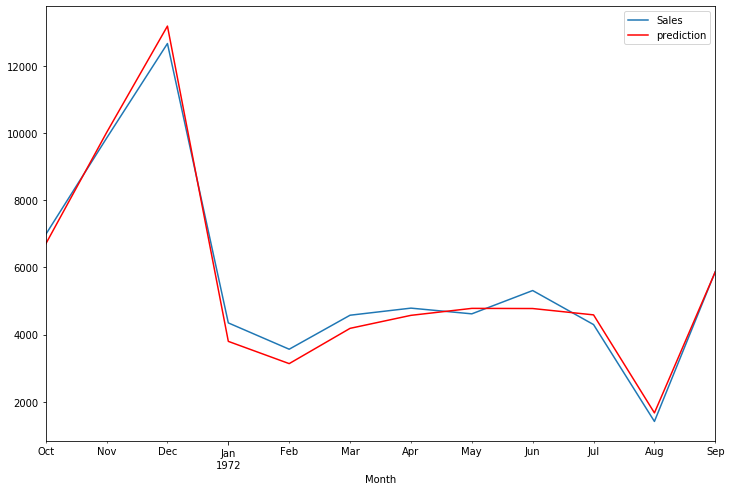

In [178]:
figure, ax = plt.subplots(figsize=(12,8))

validation.plot(ax=ax, label='Sale')
forecast.predicted_mean.plot(c='red', ax=ax, label='prediction')

plt.legend()
plt.show()

Source: Introduction to Time Series Forecasting with Python - Jason Brownlee